In [1]:
!date

Fri Jun 17 09:52:33 EDT 2022


In [2]:
pwd

'/mmfs1/data/aglinska/BC-fMRI-AE/Notebooks'

In [3]:
%%time

import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
from helper_funcs import *
import shutil
from scipy.stats import ttest_ind,ttest_1samp,ttest_rel

import umap

CPU times: user 10.5 s, sys: 6.45 s, total: 17 s
Wall time: 51.6 s


In [4]:
## BEGIN FUNCTIONS

In [5]:
def fit_rsa(rdm_data,rdm_model,measure='pearson',cov=None):
    from scipy.stats import kendalltau
    from pingouin import partial_corr
    
    if measure=='pearson':
        r = np.corrcoef(get_triu(rdm_data),get_triu(rdm_model))[0,1]
    elif measure=='kendall':
        r = kendalltau(get_triu(rdm_data),get_triu(rdm_model))[0]
    elif measure=='partial_kendall':
        arr = pd.DataFrame(np.array([get_triu(rdm_data),get_triu(rdm_model),get_triu(cov)]).transpose(),columns=['x','y','cv1'])
        r = partial_corr(data=arr, x='x', y='y', covar='cv1')['r'].values[0]
            
    return r

In [6]:
def key_rsa(inMat,key,model_scale,df,return_models=False):
    vec = df[key].values
    e = np.isnan(vec)

    model_rdm = make_RDM(vec[~e],data_scale=model_scale, metric='euclidean')
    models = []
    model_fit = []

    # Make models
    for i in range(len(inMat)):
        mat = inMat[i]['data']
        metric = inMat[i]['metric']
        data_scale = inMat[i]['data_scale']

        if mat.ndim==3:
            model_data = np.array([make_RDM(mat[i,~e,:],data_scale=data_scale, metric=metric) for i in range(10)])
        elif mat.ndim==2:
            model_data = np.array([make_RDM(mat[~e,:],data_scale=data_scale, metric=metric) for i in range(10)])
        models.append(model_data)

    for m in range(len(models)):
        model_fit.append([fit_rsa(models[m][i,:,:],model_rdm,measure='kendall') for i in range(10)])

    res = np.array(model_fit).transpose()

    if return_models==True:
        return res,models
    else:
        return res

In [7]:
def plot_nice_bar(key,rsa,ax=None,figsize=None,dpi=None,fontsize=None,fontsize_star=None,fontweight=None,line_width=None,marker_size=None,title=None,report_t=False,do_pairwise_stars=False,do_one_sample_stars=True,lbls=['VAE','BG','SL'],match_y=None):
    
    import seaborn as sns
    from scipy.stats import ttest_1samp
    from scipy.stats import ttest_ind as ttest
    
    pallete = sns.color_palette()
    pallete_new = sns.color_palette()
    
    #has_error = rsa_res[key].std(axis=0)>1e-6
    has_error = rsa[key].std(axis=0)>1e-6
    
    if not figsize:
        figsize = (5,2)
    if not dpi:
        dpi = 300
        
    if not ax:
        fig, ax = plt.subplots(1,1,figsize=figsize,dpi=dpi)

    pallete_new[1]=pallete[0]
    pallete_new[0]=pallete[1]
    pallete_new[0] = tuple(np.array((.5,.5,.5)))

    data=rsa[key]
    n = data.shape[0]
    c = data.shape[1]
    x = np.arange(c)
    
    if not fontsize:
        fontsize = 16
        
    if not fontsize_star:
        fontsize_star = 25
    if not fontweight:        
        fontweight = 'bold'
    if not line_width:    
        line_width = 2.5
    if not marker_size:            
        marker_size = .1


    for i in range(c):
        plot_data = np.zeros(data.shape)
        plot_data[:,i] = data[:,i]

        xs = np.repeat(i,n)+(np.random.rand(n)-.5)*.25
        
        if has_error[i]==True:
            sc = plt.scatter(xs,data[:,i],c='k',s = marker_size)
        b = sns.barplot(data=plot_data,errcolor='r',linewidth=line_width,errwidth=line_width,facecolor=np.hstack((np.array(pallete_new[i]),.3)),edgecolor=np.hstack((np.array(pallete_new[i]),1)))
        
        if type(match_y)!=type(None):
            plt.ylim(match_y)

    locs, labels = plt.yticks()  
    new_y = locs
    new_y = np.linspace(locs[0],locs[-1],6)
    plt.yticks(new_y,labels=[f'{yy:.2f}' for yy in new_y],fontsize=fontsize,fontweight=fontweight)
    plt.ylabel('model fit (r)',fontsize=fontsize,fontweight=fontweight)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(line_width)

    xlbls = lbls.copy()
    
    plt.xticks(np.arange(len(xlbls)),labels=xlbls,fontsize=fontsize,fontweight=fontweight)
    
    if do_one_sample_stars:
        one_sample = np.array([ttest_1samp(data[:,i],0) for i in range(len(xlbls))])
        one_sample_thresh = np.array((1,.05,.001,.0001))
        one_sample_stars = np.array(('n.s.','*','**','***'))
        xlbls = lbls.copy()
        for i in range(0,c):
            if has_error[i]==True:
                these_stars = one_sample_stars[max(np.nonzero(one_sample[i,1]<one_sample_thresh)[0])]
                xlbls[i] = f'{xlbls[i]}\n({these_stars})'
        plt.xticks(np.arange(len(xlbls)),labels=xlbls,fontsize=fontsize,fontweight=fontweight,horizontalalignment='center',multialignment='center')

    pairwise_t = np.zeros((3,3))
    pairwise_p = np.zeros((3,3))

    pairwise_sample_thresh = np.array((1,.05,.001,.0001))
    pairwise_sample_stars = np.array(('n.s.','*','**','***'))

    if report_t:
        for i in range(c):
            for j in range(c):
                t,p = ttest(data[:,i],data[:,j])
                mnames = lbls.copy()

                if p > .001:
                    print(f'{key} {mnames[i]} >  {mnames[j]} | t({data.shape[0]-1}) = {t:.2f} p = {p:.2f}')
                else:
                    print(f'{key} {mnames[i]} >  {mnames[j]} | t({data.shape[0]-1}) = {t:.2f} p $<$ .001')
                pairwise_t[i,j] = t
                pairwise_p[i,j] = p

    comps = [[1,2]]
    if do_pairwise_stars:
        for comp_idx in range(len(comps)):
            this_comp = comps[comp_idx]
            sig_idx = max(np.nonzero(pairwise_p[this_comp[0],this_comp[1]]<pairwise_sample_thresh)[0])
            max_y = new_y[-1] + comp_idx*.05
            xs = np.array(this_comp)
            stars = pairwise_sample_stars[sig_idx]
            plt.plot(xs,[max_y,max_y],'k',linewidth=line_width)
            plt.text(xs.mean(),max_y,stars,fontsize=fontsize_star,horizontalalignment='center',fontweight=fontweight)
        
    ylim = plt.ylim()
    plt.ylim(np.array(ylim)*(1,1.1))
    
    if not title:
        plt.title(key,fontsize=fontsize*1.5,pad=2,fontweight=fontweight)    
    else:
        plt.title(title,fontsize=fontsize*1.5,pad=2,fontweight=fontweight)    
        

In [8]:
def key_rsa_partial(inMat,key,model_scale,df_use,return_models=False,cov=None):
    vec = df_use[key].values
    e = np.isnan(vec)

    model_rdm = make_RDM(vec[~e],data_scale=model_scale, metric='euclidean')
    models = []
    model_fit = []

    # Make models
    for i in range(len(inMat)):
        mat = inMat[i]['data']
        metric = inMat[i]['metric']
        data_scale = inMat[i]['data_scale']

        if mat.ndim==3:
            model_data = np.array([make_RDM(mat[i,~e,:],data_scale=data_scale, metric=metric) for i in range(10)])
        elif mat.ndim==2:
            model_data = np.array([make_RDM(mat[~e,:],data_scale=data_scale, metric=metric) for i in range(10)])
        models.append(model_data)

    if type(cov)==type(None):
        cov_rdm = make_RDM(df_use['site_id'].values[~e],data_scale='ordinal', metric='euclidean')
    else:
        cov_rdm = make_RDM(cov[~e])
        
    for m in range(len(models)):
        model_fit.append([fit_rsa(models[m][i,:,:],model_rdm,measure='partial_kendall',cov=cov_rdm) for i in range(10)])
        

    res = np.array(model_fit).transpose()

    if return_models==True:
        return res,models
    else:
        return res

In [9]:
def dummy_ordinal(invec):
    unique_values = np.unique(invec)
    new_values = np.arange(1,len(unique_values)+1)
    new_arr = [new_values[val==unique_values][0] for val in invec]
    return new_arr

In [10]:
def flatten_cmat(cmats):
    ns = cmats.shape[0]
    ni = cmats.shape[-1]
    tridx = np.triu_indices(n=ni,k=1)
    mat_flat = np.array([cmats[i,:,:][tridx] for i in range(ns)])
    return mat_flat

In [11]:
# END OF FUNCTIONS

In [12]:
analysis_name = 'CVAE_2022-03-25 18:28:49.469238'
save_dir = os.path.join('../Assets/tf_weights',analysis_name)

In [13]:
# YEO ROI NAMES
rnames = ['LH-Vis-EVC','LH-SomMot-Mot','LH-DorsAttn-Post','LH-DorsAttn-FEF','LH-DorsAttn-PrCv','LH-SalVentAttn-ParOper','LH-SalVentAttn-TempOcc','LH-SalVentAttn-FrOper','LH-SalVentAttn-PFCl','LH-SalVentAttn-Med','LH-Limbic-OFC','LH-Limbic-TempPole','LH-Cont-Par','LH-Cont-Temp','LH-Cont-PFCd','LH-Cont-PFCl','LH-Cont-OFC','LH-Cont-PFCv','LH-Cont-pCun','LH-Cont-Cing','LH-Cont-PFCmp','LH-Default-Par','LH-Default-Temp','LH-Default-PFC','LH-Default-PCC','LH-Default-PHC','RH-Vis-EVC','RH-SomMot-Mot','RH-DorsAttn-Post','RH-DorsAttn-FEF','RH-DorsAttn-PrCv','RH-SalVentAttn-TempOccPar','RH-SalVentAttn-PrC','RH-SalVentAttn-FrOper','RH-SalVentAttn-PFCv','RH-SalVentAttn-PFCl','RH-SalVentAttn-Med','RH-Limbic-OFC','RH-Limbic-TempPole','RH-Cont-Par','RH-Cont-Temp','RH-Cont-PFCv','RH-Cont-PFCl','RH-Cont-pCun','RH-Cont-Cing','RH-Cont-PFCmp','RH-Default-Par','RH-Default-Temp','RH-Default-PFCv','RH-Default-PFCm','RH-Default-PCC']

In [14]:
df = pd.read_csv('../Data/comb_df.csv')
df['dataset_id'] = dummy_ordinal(df['dataset'])
df['site_id'] = dummy_ordinal(df['site'])


u_sites = np.unique(df['site_id'].values)
sites = df['site_id'].values.astype(float)
site_ratios = np.array([(df['diag'].values[df['site_id'].values==s]==1).mean() for s in u_sites])
bad_sites = u_sites[abs(site_ratios-.5)>.1]
sites[df['site_id'].isin(bad_sites).values] = np.nan
df['sites_bal'] = sites
print((~np.isnan(df['sites_bal'].values)).sum())


patients = df['diag'].values==1
df_asd = df.iloc[patients]
df_td = df.iloc[~patients]

print(df_asd.shape)
print(df_td.shape)

df

1025
(661, 16)
(841, 16)


,Unnamed: 0,participant_id,diag,age,sex,fiq,site,DSMIV,ados_total,ados_social,ados_comm,ados_rrb,dataset,dataset_id,site_id,sites_bal
0,0,50002,1,16.77,1,103.0,13,1.0,12.0,8.0,4.0,3.0,ABIDE I,1,4,4.0
1,2,50004,1,19.09,1,113.0,13,1.0,18.0,12.0,6.0,2.0,ABIDE I,1,4,4.0
2,3,50005,1,13.73,2,119.0,13,1.0,12.0,8.0,4.0,1.0,ABIDE I,1,4,4.0
3,4,50006,1,13.37,1,109.0,13,1.0,12.0,8.0,4.0,4.0,ABIDE I,1,4,4.0
4,9,50011,1,16.93,1,111.0,13,1.0,13.0,9.0,4.0,NaN,ABIDE I,1,4,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1497,746,30163,2,8.00,2,136.0,ABIDEII-OHSU_1,NaN,NaN,NaN,NaN,NaN,ABIDE II,2,29,NaN
1498,747,30164,2,10.00,2,115.0,ABIDEII-OHSU_1,NaN,NaN,NaN,NaN,NaN,ABIDE II,2,29,NaN
1499,748,30165,2,12.00,2,120.0,ABIDEII-OHSU_1,NaN,NaN,NaN,NaN,NaN,ABIDE II,2,29,NaN
1500,749,30166,2,10.00,2,112.0,ABIDEII-OHSU_1,NaN,NaN,NaN,NaN,NaN,ABIDE II,2,29,NaN


In [15]:
## Load Data
cmats = np.load('../Data/cmats_r51_S1502.npz')['data']
cmats_rel = np.load('../Data/rel-cmats_r51_S1502.npz')['data']
cmats_asd_flat = flatten_cmat(cmats[patients,:,:])

print(cmats.shape)
print(cmats_rel.shape)
print(cmats_asd_flat.shape)

(1502, 51, 51)
(1502, 2, 51, 51)
(661, 1275)


In [16]:
def depad(mat,idx=(6,57)):
    'depads the cmats'
    if mat.ndim==3:
        mat_trimmed = mat[:,idx[0]:idx[1],idx[0]:idx[1]]
    elif mat.ndim==4:
        mat_trimmed = mat[:,:,idx[0]:idx[1],idx[0]:idx[1]]
    else:
        print(mat.shape)
        raise Exception("Not implemented")
        
    return mat_trimmed

In [17]:
def plot_scatterbar(inData,lbls):
#inData = [v1,v2]
#lbls = ['LH','RH']
    n = len(inData)

    plt.bar(np.arange(n),[v.mean() for v in inData],alpha=.5)

    for i in range(n):
        ys = inData[i]
        xs = np.ones(ys.shape)*i
        xs = xs+(np.random.rand(xs.shape[0])-.5)*.1
        plt.scatter(xs,ys);

    plt.xticks(np.arange(n),labels=lbls);

In [18]:
%%time

data = np.load(os.path.join(save_dir,'results.npz'))
data = dict(data)
data_keys = list(data.keys())

# Z_mu = data['Z_mu']
# Z_sigma = data['Z_sigma']
# Z = data['Z']
# S_mu = data['S_mu']
# S_sigma = data['S_sigma']
# S = data['S']
# Z_sample100 = data['Z_sample100']
# S_sample100 = data['S_sample100']

data['recon_td_mu'] = depad(data['recon_td_mu'])
data['recon_asd_mu'] = depad(data['recon_asd_mu'])
data['recon_twin_mu'] = depad(data['recon_twin_mu'])
data['recon_td_samples'] = depad(data['recon_td_samples'])
data['recon_asd_samples'] = depad(data['recon_asd_samples'])
data['recon_twin_samples'] = depad(data['recon_twin_samples'])

data['Z_asd_sample10'] = data['Z_sample100'][0:10,patients,:]
data['S_asd_sample10'] = data['S_sample100'][0:10,patients,:]

for key in data_keys:
    print(f'{key.center(20)} | {data[key].shape}')

        Z_mu         | (1502, 16)
      Z_sigma        | (1502, 16)
         Z           | (1502, 16)
        S_mu         | (1502, 16)
      S_sigma        | (1502, 16)
         S           | (1502, 16)
    Z_sample100      | (100, 1502, 16)
    S_sample100      | (100, 1502, 16)
    recon_td_mu      | (841, 51, 51)
    recon_asd_mu     | (661, 51, 51)
   recon_twin_mu     | (661, 51, 51)
  recon_td_samples   | (100, 841, 51, 51)
 recon_asd_samples   | (100, 661, 51, 51)
 recon_twin_samples  | (100, 661, 51, 51)
CPU times: user 20.8 s, sys: 723 ms, total: 21.5 s
Wall time: 21.6 s


In [19]:
twin_pc = PCA(n_components=1).fit_transform(flatten_cmat(data['recon_twin_mu']))[:,0]

In [20]:
v1 = ((cmats[patients,:,:]-data['recon_asd_mu'])**2).mean(axis=-1).mean(axis=-1)
v2 = ((cmats[~patients,:,:]-data['recon_td_mu'])**2).mean(axis=-1).mean(axis=-1)
v3 = ((cmats[patients,:,:]-data['recon_twin_mu'])**2).mean(axis=-1).mean(axis=-1)

/data/aglinska/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data/aglinska/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


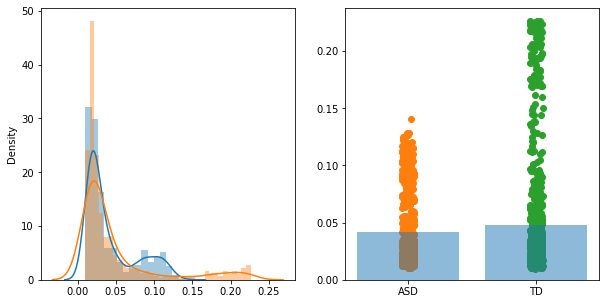

In [21]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.distplot(v1)
sns.distplot(v2)
plt.subplot(1,2,2)
#plot_scatterbar([v1,v2,v3],['ASD','TD','Twin'])
plot_scatterbar([v1,v2],['ASD','TD'])

In [22]:
ttest_ind(v1,v2)

Ttest_indResult(statistic=-2.484322707191519, pvalue=0.013088231401197014)

In [23]:
def get_fd(sub):
    '''takes in a sub, returns average FD'''
    if df.loc[df['participant_id'] == sub]['dataset_id'].values[0]==2:
        temp = f'~/data/ABIDE2/Derivatives/preprocessed/sub-{sub}'
        temp = os.path.expanduser(temp)
        folders = os.listdir(temp)
        folders.sort()
        csv = [file for file in os.listdir(os.path.join(temp,folders[0])) if file.endswith('csv')]
        mot = pd.read_csv(os.path.join(os.path.join(temp,folders[0],csv[0])))
        
        #fd = np.nanmean(mot['framewise_displacement'].values)
        fd = np.nansum(mot['framewise_displacement'].values)
        
    elif df.loc[df['participant_id'] == sub]['dataset_id'].values[0]==1:
        conf_fn = '~/data/ABIDE/Derivatives/preprocessed/sub-00{sub}/conf-sub-00{sub}.csv'
        temp = pd.read_csv(conf_fn.format(sub=sub))
        
        #fd = np.nanmean(temp['framewise_displacement'].values)
        fd = np.nansum(temp['framewise_displacement'].values)
    return fd

FDs = np.array([get_fd(subID) for subID in tqdm(df['participant_id'].values[patients])])
df_asd['FDs'] = FDs

100%|██████████| 661/661 [00:21<00:00, 30.06it/s]
<ipython-input-23-209e2f33c74b>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_asd['FDs'] = FDs


In [24]:
FDs_td = np.array([get_fd(subID) for subID in tqdm(df['participant_id'].values[~patients])])

100%|██████████| 841/841 [00:27<00:00, 30.67it/s]


/data/aglinska/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data/aglinska/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Framewise Displacement by group')

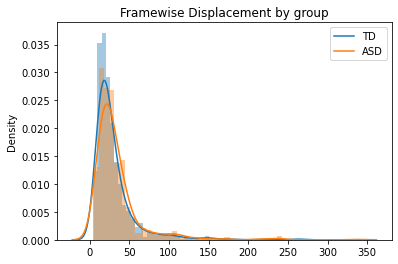

In [25]:
sns.distplot(FDs_td)
sns.distplot(FDs)
plt.legend(['TD','ASD'])
plt.title('Framewise Displacement by group')

In [26]:
def pretty_t_ind(v1,v2,return_statement=False):
    from scipy.stats import ttest_ind
    degf = len(v1)+len(v2)-2
    t,p = ttest_ind(v2,v1)

    if p<.001:
        t_statement = f't({degf}) = {t:.2f}, p < .001'
    else:
        t_statement = f't({degf}) = {t:.2f}, p = {p:.2}'
    if return_statement==True:
        return t_statement
    else:
        print(t_statement)

In [27]:
pretty_t_ind(FDs,FDs_td)

t(1500) = -2.53, p = 0.011


In [28]:
data.keys()

dict_keys(['Z_mu', 'Z_sigma', 'Z', 'S_mu', 'S_sigma', 'S', 'Z_sample100', 'S_sample100', 'recon_td_mu', 'recon_asd_mu', 'recon_twin_mu', 'recon_td_samples', 'recon_asd_samples', 'recon_twin_samples', 'Z_asd_sample10', 'S_asd_sample10'])

/data/aglinska/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data/aglinska/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data/aglinska/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

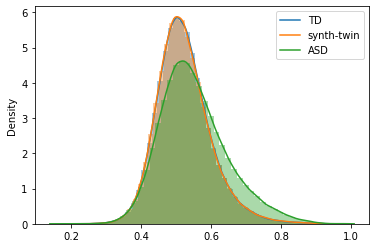

In [29]:
sns.distplot(flatten_cmat(data['recon_td_mu']))
sns.distplot(flatten_cmat(data['recon_twin_mu']))
sns.distplot(flatten_cmat(data['recon_asd_mu']))
plt.legend(['TD','synth-twin', 'ASD'])

In [30]:
flatten_cmat(data['recon_asd_mu'])

array([[0.54414886, 0.636129  , 0.4962323 , ..., 0.61267596, 0.45533726,
        0.70375127],
       [0.47175288, 0.49701715, 0.414271  , ..., 0.6757072 , 0.49184427,
        0.68058705],
       [0.53675085, 0.58027446, 0.5160431 , ..., 0.6399803 , 0.52825207,
        0.70309204],
       ...,
       [0.5227518 , 0.52846354, 0.4881757 , ..., 0.6079657 , 0.46323547,
        0.7265967 ],
       [0.5491991 , 0.71346664, 0.59700024, ..., 0.6212559 , 0.5060485 ,
        0.679415  ],
       [0.40819973, 0.5592227 , 0.49052817, ..., 0.7435047 , 0.54353684,
        0.7108867 ]], dtype=float32)

In [31]:
flatten_cmat(cmats[patients,:,:])

array([[0.76895615, 0.9166674 , 0.73805892, ..., 0.69149577, 0.77145626,
        0.80350022],
       [0.70393653, 0.71853239, 0.6609765 , ..., 0.79326103, 0.56723386,
        0.73496145],
       [0.84202787, 0.88598425, 0.84347797, ..., 0.90153102, 0.66307746,
        0.7912658 ],
       ...,
       [0.69305057, 0.70591658, 0.66698792, ..., 0.74258459, 0.64895224,
        0.68902955],
       [0.75252601, 0.64299766, 0.62081296, ..., 0.71997895, 0.44961025,
        0.72989684],
       [0.72249257, 0.8441842 , 0.77481399, ..., 0.54970519, 0.42008003,
        0.8465939 ]])

<AxesSubplot:>

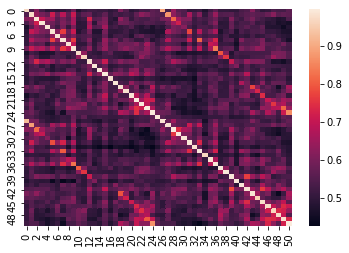

In [32]:
sns.heatmap(data['recon_asd_mu'].mean(axis=0))

<AxesSubplot:>

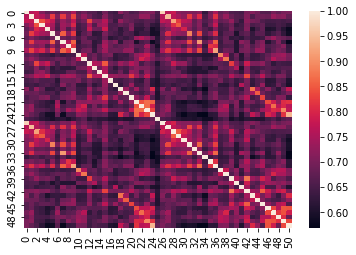

In [33]:
sns.heatmap(cmats[patients,:,:].mean(axis=0))

/data/aglinska/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data/aglinska/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


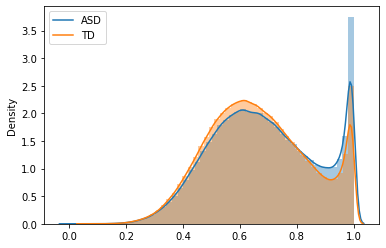

In [34]:
sns.distplot(flatten_cmat(cmats[patients,:,:]))
sns.distplot(flatten_cmat(cmats[~patients,:,:]))
plt.legend(['ASD','TD'])

In [35]:
m1 = flatten_cmat(cmats[patients,:,:])
m2 = flatten_cmat(data['recon_asd_mu'])
svec = np.arange(m1.shape[0])

In [36]:
def dist(vec1,vec2):
    return np.corrcoef(vec1,vec2)[0,1]

In [37]:
ranks = []
for s in tqdm(svec):
    corr_vec = np.array([dist(m1[s,:],m2[i,:]) for i in svec])
    ranks.append(sum(corr_vec[s]<corr_vec[svec!=s])+1)
ranks = np.array(ranks)

100%|██████████| 661/661 [00:29<00:00, 22.52it/s]


In [38]:
np.median(ranks)

258.0

In [39]:
data.keys()

dict_keys(['Z_mu', 'Z_sigma', 'Z', 'S_mu', 'S_sigma', 'S', 'Z_sample100', 'S_sample100', 'recon_td_mu', 'recon_asd_mu', 'recon_twin_mu', 'recon_td_samples', 'recon_asd_samples', 'recon_twin_samples', 'Z_asd_sample10', 'S_asd_sample10'])

In [40]:
diffmat = (data['recon_asd_mu']-data['recon_twin_mu'])
diffmat_flat = flatten_cmat(diffmat)
diffmat_flat_samples = np.array([flatten_cmat((data['recon_asd_samples']-data['recon_twin_samples'])[i,:,:,:]) for i in range(10)])

In [41]:
from sklearn.linear_model import LinearRegression

In [42]:
diffmat_resid = np.array([diffmat_flat[:,i][:,np.newaxis]-LinearRegression().fit(FDs[:,np.newaxis] , diffmat_flat[:,i][:,np.newaxis]).predict(FDs[:,np.newaxis]) for i in range(diffmat_flat.shape[1])])
diffmat_resid = diffmat_resid[:,:,0].transpose()
diffmat_resid.shape

(661, 1275)

In [43]:
diffmat_resid_samples = [np.array([diffmat_flat_samples[j,:,i][:,np.newaxis]-LinearRegression().fit(FDs[:,np.newaxis] , diffmat_flat_samples[j,:,i][:,np.newaxis]).predict(FDs[:,np.newaxis]) for i in range(diffmat_flat.shape[1])]) for j in tqdm(range(10))]
diffmat_resid_samples = np.array(diffmat_resid_samples)[:,:,:,0]

100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


In [44]:
v1 = {'label' : 'CMAT', 'data' : cmats_asd_flat, 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v2 = {'label' : 'DMAT', 'data' : diffmat_flat_samples, 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v3 = {'label' : 'BG', 'data' : data['Z_asd_sample10'], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v4 = {'label' : 'SL', 'data' : data['S_asd_sample10'], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v5 = {'label' : 'FDs', 'data' : FDs[:,np.newaxis], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v6 = {'label' : 'DR', 'data' : diffmat_resid_samples, 'data_scale' : 'ratio', 'metric' : 'euclidean'}

In [45]:
#data['Z_asd_sample10'].shape

In [46]:
inMat = [v1,v2,v3,v4,v5]
#inMat = [v1,v2,v6]

In [47]:
rsa_res = dict()
keys = ['dataset_id', 'sites_bal','age', 'sex', 'fiq','DSMIV','ados_total', 'ados_social', 'ados_comm', 'ados_rrb']
data_scale = ['ordinal', 'ordinal','ratio', 'ordinal', 'ratio','ordinal','ratio', 'ratio', 'ratio', 'ratio']

for i in tqdm(range(len(keys))):
    rsa_res.update({keys[i] : key_rsa(inMat,keys[i],df=df_asd,model_scale=data_scale[i])})

  0%|          | 0/10 [00:00<?, ?it/s]/data/aglinska/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/data/aglinska/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
100%|██████████| 10/10 [01:10<00:00,  7.04s/it]


In [48]:
rsa_res2 = dict()
keys = ['dataset_id', 'sites_bal','age', 'sex', 'fiq','DSMIV','ados_total', 'ados_social', 'ados_comm', 'ados_rrb']
data_scale = ['ordinal', 'ordinal','ratio', 'ordinal', 'ratio','ordinal','ratio', 'ratio', 'ratio', 'ratio']

for i in tqdm(range(len(keys))):
    rsa_res2.update({keys[i] : key_rsa_partial(inMat,keys[i],df_use=df_asd,model_scale=data_scale[i])})

100%|██████████| 10/10 [01:05<00:00,  6.58s/it]


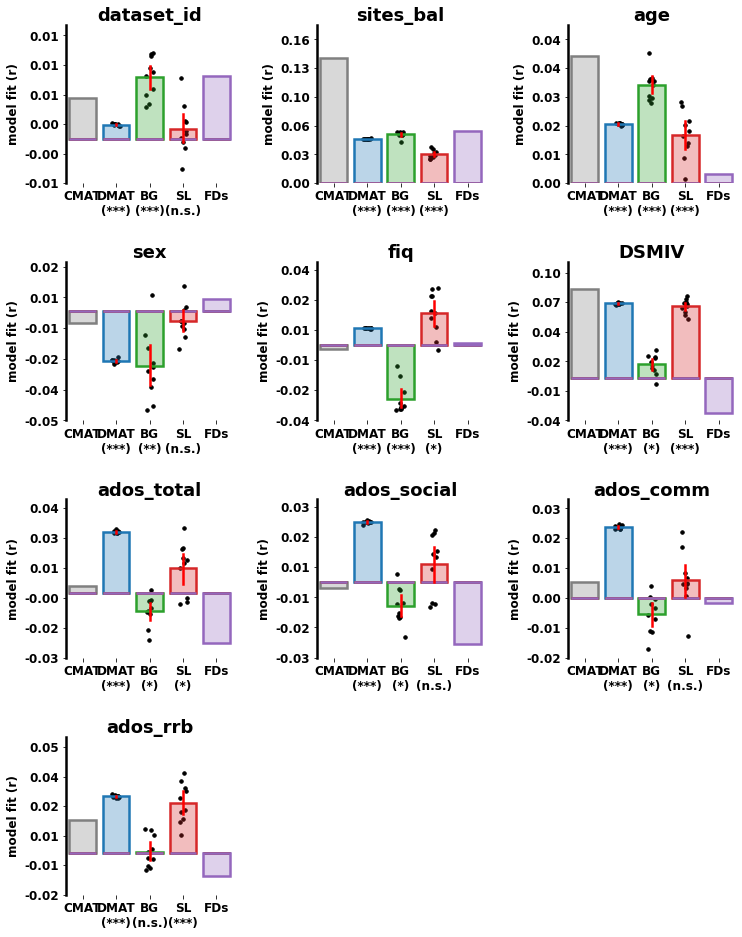

In [49]:
ncols = 3
nrows = int(np.ceil(len(keys)/3))
plt.figure(figsize=np.array((ncols,nrows))*4)

for i,key in enumerate(keys):
    ax = plt.subplot(nrows,ncols,i+1)
    plot_nice_bar(key,rsa_res,
                  ax=ax,figsize=None,
                  dpi=300,fontsize=12,
                  fontsize_star=12,
                  fontweight='bold',
                  line_width=2.5,
                  marker_size=12,title=keys[i],lbls=[inMat[j]['label'] for j in range(len(inMat))])
    
plt.subplots_adjust(
    left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=.5,
    hspace=.5)

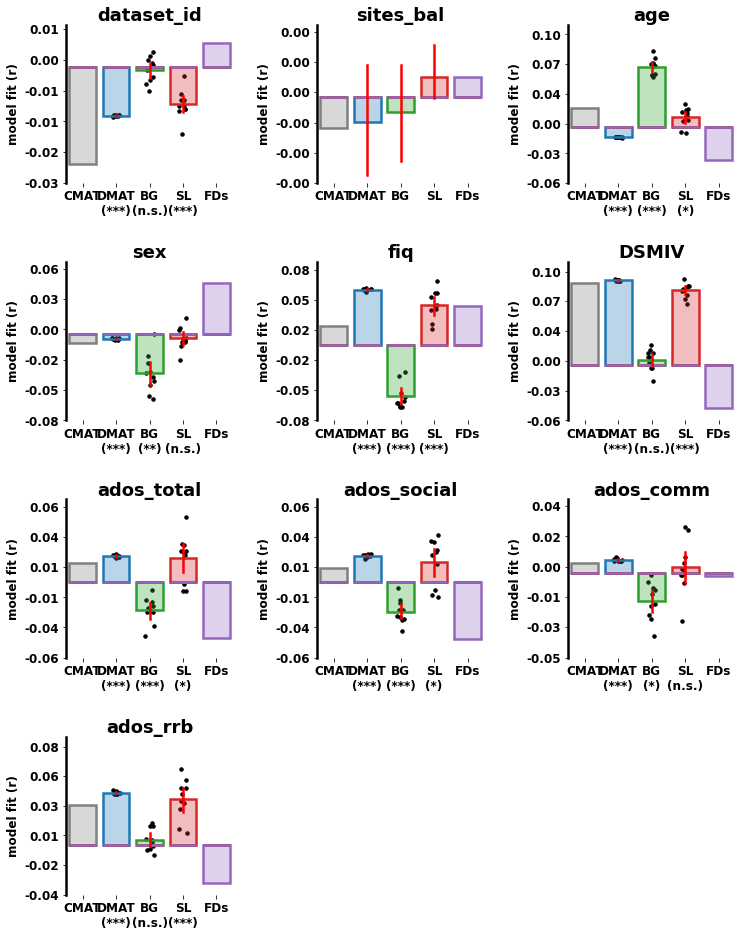

In [50]:
ncols = 3
nrows = int(np.ceil(len(keys)/3))
plt.figure(figsize=np.array((ncols,nrows))*4)

for i,key in enumerate(keys):
    ax = plt.subplot(nrows,ncols,i+1)
    plot_nice_bar(key,rsa_res2,
                  ax=ax,figsize=None,
                  dpi=300,fontsize=12,
                  fontsize_star=12,
                  fontweight='bold',
                  line_width=2.5,
                  marker_size=12,title=keys[i],lbls=[inMat[j]['label'] for j in range(len(inMat))])
    
plt.subplots_adjust(
    left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=.5,
    hspace=.5)

In [51]:
td1 = {'label' : 'CMAT', 'data' : flatten_cmat(cmats[~patients,:,:]), 'data_scale' : 'ratio', 'metric' : 'euclidean'}
td2 = {'label' : 'BG', 'data' : data['Z_mu'][~patients,:], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
td3 = {'label' : 'SL', 'data' : data['S_mu'][~patients,:], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
tdMat = [td1,td2,td3]

rsa_res_td = dict()
keys = ['dataset_id', 'sites_bal','age', 'sex', 'fiq']
data_scale = ['ordinal', 'ordinal','ratio', 'ordinal', 'ratio']

for i in tqdm(range(len(keys))):
    rsa_res_td.update({keys[i] : key_rsa(tdMat,keys[i],df=df.iloc[~patients],model_scale=data_scale[i])})

100%|██████████| 5/5 [00:32<00:00,  6.54s/it]


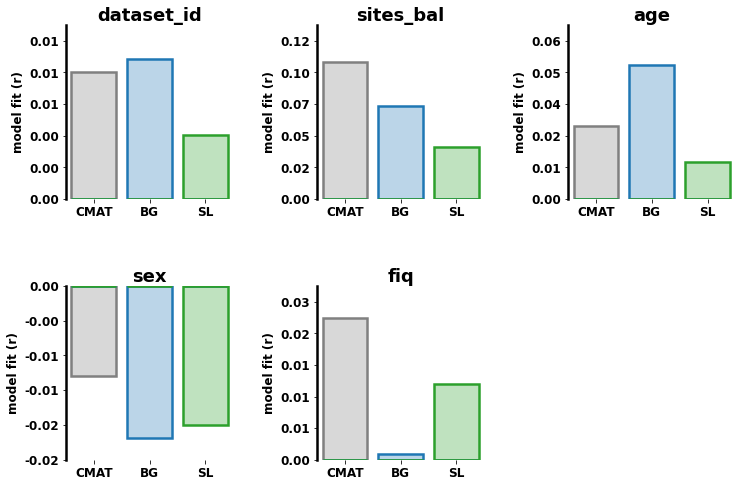

In [52]:
ncols = 3
nrows = int(np.ceil(len(keys)/3))
plt.figure(figsize=np.array((ncols,nrows))*4)

for i,key in enumerate(keys):
    ax = plt.subplot(nrows,ncols,i+1)
    plot_nice_bar(key,rsa_res_td,
                  ax=ax,figsize=None,
                  dpi=300,fontsize=12,
                  fontsize_star=12,
                  fontweight='bold',
                  line_width=2.5,
                  marker_size=12,title=keys[i],lbls=[tdMat[j]['label'] for j in range(len(tdMat))])
    
plt.subplots_adjust(
    left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=.5,
    hspace=.5)

In [53]:
from sklearn.linear_model import LogisticRegression,LinearRegression,ElasticNet,Ridge
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

In [54]:
### PCA

In [55]:
diffmat_asd_flat = flatten_cmat(diffmat)
diffmat_asd_flat.shape

(661, 1275)

In [56]:
reducer = PCA()
comps = reducer.fit_transform(diffmat_asd_flat)
#comps = UMAP(n_components=10).fit_transform(diffmat_asd_flat)
#comps = reducer.fit_transform(cmats_asd_flat)
comps.shape

(661, 661)

In [57]:
(reducer.explained_variance_ratio_[0:10]*100).round(2)

array([44.74,  3.59,  2.66,  2.47,  2.22,  1.92,  1.7 ,  1.39,  1.28,
        1.15], dtype=float32)

In [58]:
diffmat_asd_flat.shape

(661, 1275)

In [59]:
est_pca=False
if est_pca:
    from datetime import datetime
    t0 = datetime.now()
    print(t0)
    loso_comp_samples = [[PCA().fit(diffmat_resid_samples[j,:,:].transpose()[np.arange(n)!=s,:]).transform(diffmat_resid_samples[j,:,:].transpose()[s,:][np.newaxis,:]) for s in range(n)] for j in range(10)]
    np.save(file='../Data/loso_comp_samples_new.npy', arr=np.array(loso_comp_samples)[:,:,0,:])
    print(datetime.now()-t0)
    

In [60]:
pca_ = PCA()
pca_.fit(diffmat_resid)

PCA()

first 3 PCs explain 53.44% var
82 PCs are needed to explain 90% of variance


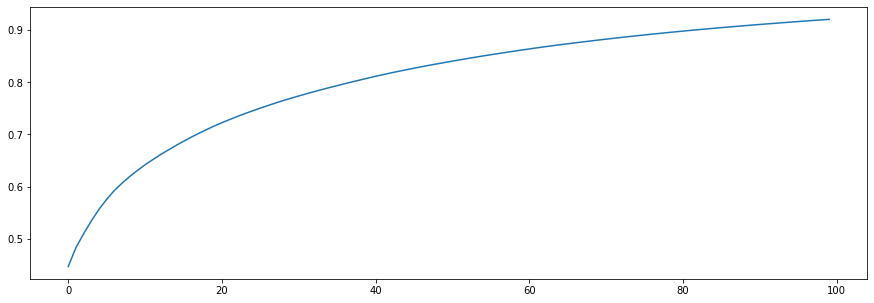

In [61]:
plt.figure(figsize=(15,5))
cumsum = np.cumsum(pca_.explained_variance_ratio_)
cumsum = cumsum[0:100]
plt.plot(cumsum)
print(f'first 3 PCs explain {cumsum[3]*100:.2f}% var')
print(f'{sum(cumsum<.9)} PCs are needed to explain 90% of variance')

In [62]:
loso_comp_samples = np.load('../Data/loso_comp_samples.npy')
loso_comp_samples.shape

(10, 661, 660)

In [63]:
est_pca = False
if est_pca:
    #inMat = diffmat_asd_flat
    inMat = diffmat_resid
    n = inMat.shape[0]
    loso_comp = np.array([PCA().fit(inMat[np.arange(n)!=s,:]).transform(inMat[s,:][np.newaxis,:]) for s in tqdm(range(n))])
    np.save(file='../Data/loso_comp.npy', arr=np.array(loso_comp[:,0,:]))
else:
    loso_comp = np.load('../Data/loso_comp.npy')

In [64]:
#comps = loso_comp[:,0,:]
comps = np.array(loso_comp_samples)

In [65]:
comps.shape

(10, 661, 660)

In [66]:
from scipy.spatial.distance import squareform
from scipy.stats import pearsonr

In [67]:
v1 = {'label' : 'PC1', 'data' : comps[:,:,0][:,:,np.newaxis], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v2 = {'label' : 'PC2', 'data' : comps[:,:,1][:,:,np.newaxis], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v3 = {'label' : 'PC3', 'data' : comps[:,:,2][:,:,np.newaxis], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v4 = {'label' : 'PC4', 'data' : comps[:,:,3][:,:,np.newaxis], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v5 = {'label' : 'PC5', 'data' : comps[:,:,4][:,:,np.newaxis], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v6 = {'label' : 'PC6', 'data' : comps[:,:,5][:,:,np.newaxis], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v7 = {'label' : 'PC7', 'data' : comps[:,:,6][:,:,np.newaxis], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v8 = {'label' : 'PC8', 'data' : comps[:,:,7][:,:,np.newaxis], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v9 = {'label' : 'PC9', 'data' : comps[:,:,8][:,:,np.newaxis], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v10 = {'label' : 'PC10', 'data' : comps[:,:,9][:,:,np.newaxis], 'data_scale' : 'ratio', 'metric' : 'euclidean'}

In [68]:
inMat = [v1,v2,v3,v4,v5,v6,v7,v8,v9,v10]

In [69]:
v1['data'].shape

(10, 661, 1)

In [70]:
rsa_res = dict()
rsa_res_partial = dict()
keys = ['dataset_id', 'sites_bal','age', 'sex', 'fiq','DSMIV','ados_total', 'ados_social', 'ados_comm', 'ados_rrb','FDs']
data_scale = ['ordinal', 'ordinal','ratio', 'ordinal', 'ratio','ordinal','ratio', 'ratio', 'ratio', 'ratio','ratio']
#cov = make_RDM(FDs)
for i in tqdm(range(len(keys))):
    rsa_res.update({keys[i] : key_rsa(inMat,keys[i],df=df_asd,model_scale=data_scale[i])})
    rsa_res_partial.update({keys[i] : key_rsa_partial(inMat,keys[i],df_use=df_asd,model_scale=data_scale[i],cov=None)})

100%|██████████| 11/11 [01:07<00:00,  6.11s/it]


Text(0.5, 0.98, 'FDs NOT partialled out')

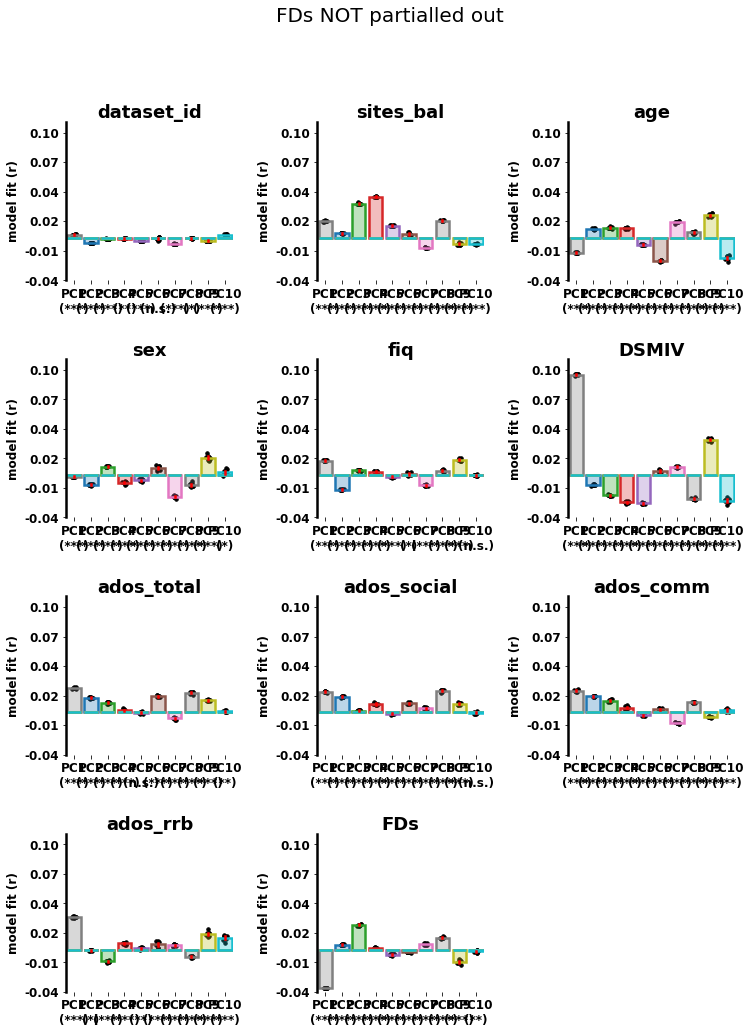

In [71]:
ncols = 3
nrows = int(np.ceil(len(keys)/3))
plt.figure(figsize=np.array((ncols,nrows))*4)

temp = np.array([rsa_res[k] for k in list(rsa_res.keys())])
ylim = (temp.min(),temp.max())

for i,key in enumerate(keys):
    ax = plt.subplot(nrows,ncols,i+1)
    plot_nice_bar(key,rsa_res,
                  ax=ax,figsize=None,
                  dpi=300,fontsize=12,
                  fontsize_star=12,
                  fontweight='bold',
                  line_width=2.5,
                  marker_size=12,
                  title=keys[i],
                  lbls=[inMat[j]['label'] for j in range(len(inMat))],
                  match_y=ylim
                 )
    
plt.subplots_adjust(
    left=None,
    bottom= None,
    right=None,
    top=None,
    wspace=.5,
    hspace=.5)

plt.suptitle('FDs NOT partialled out',fontsize=20)

Text(0.5, 0.98, 'FDs partialled out')

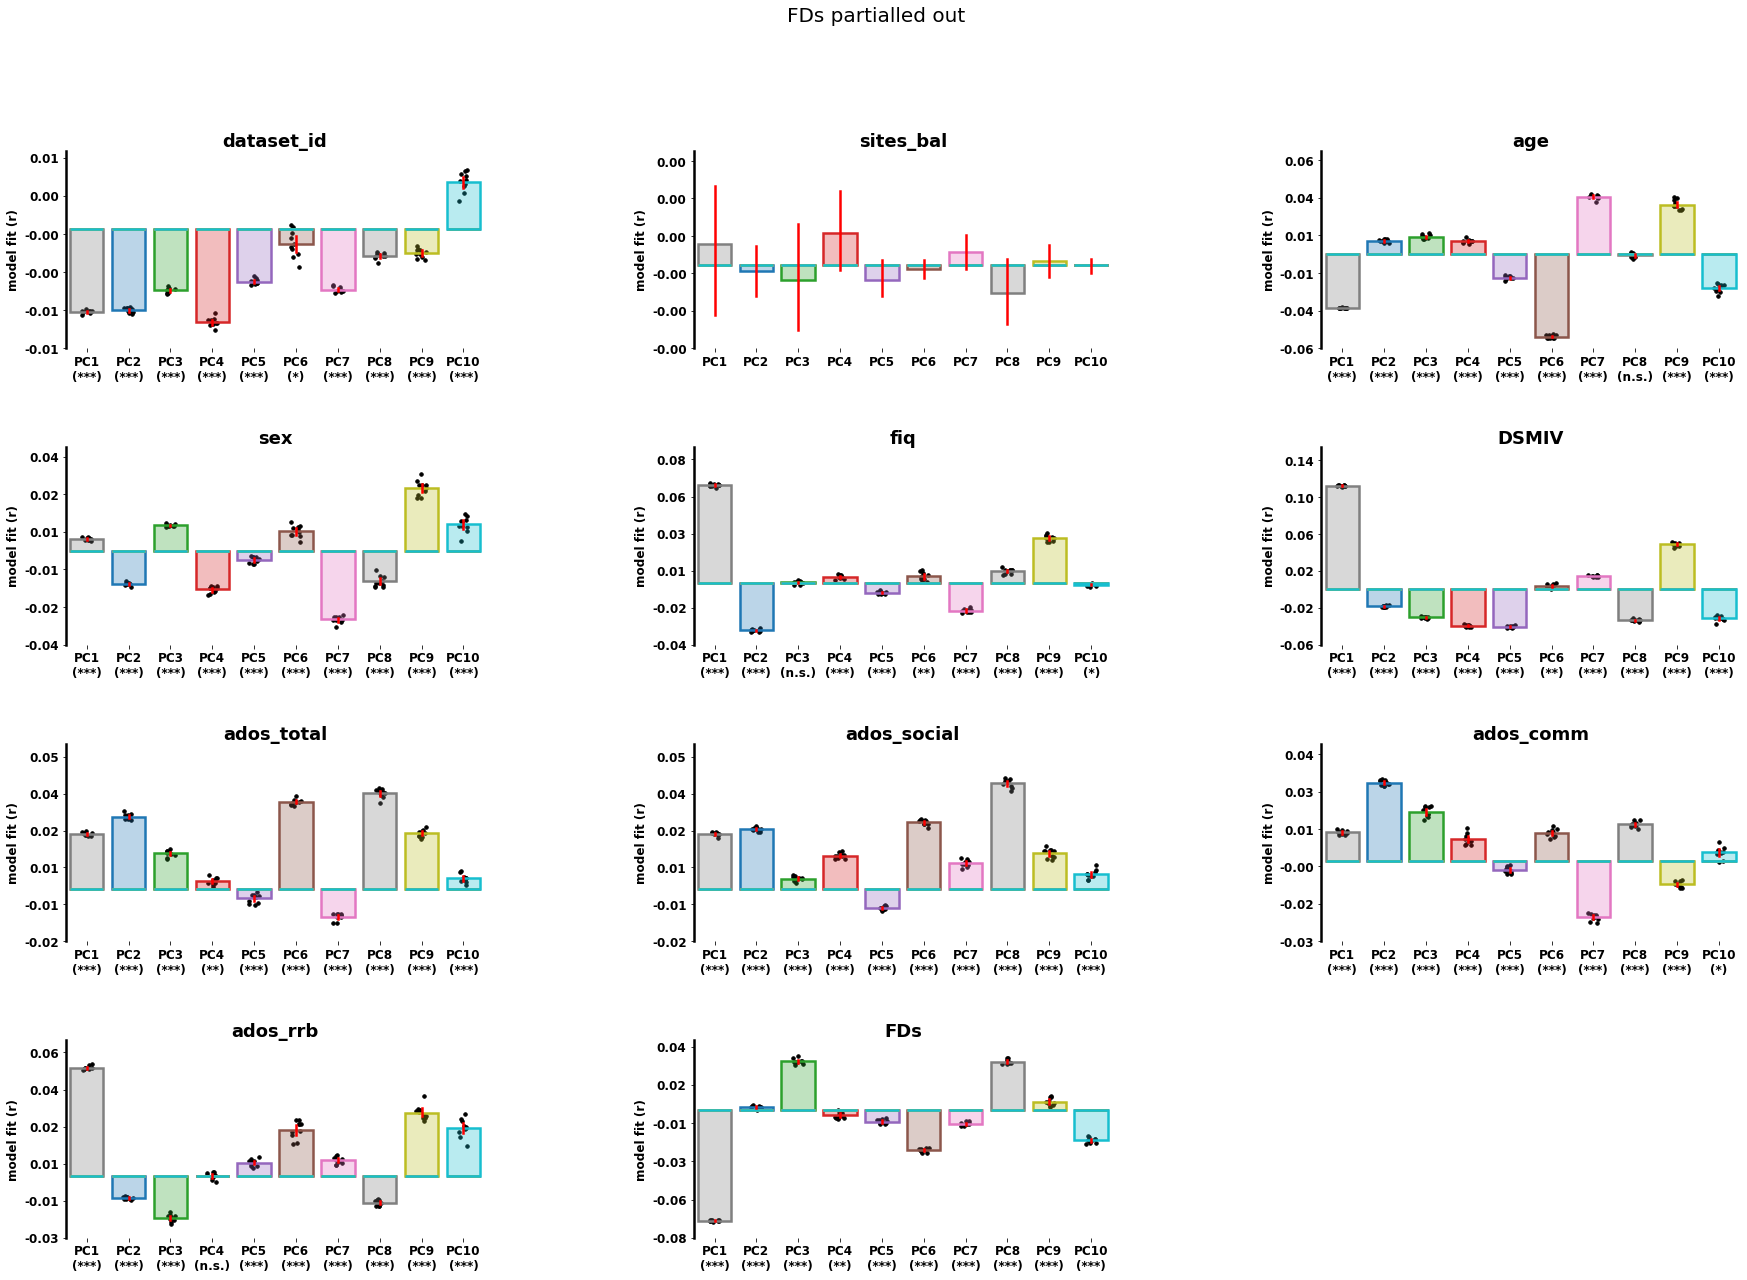

In [72]:
ncols = 3
nrows = int(np.ceil(len(keys)/3))
plt.figure(figsize=np.array((ncols*2,nrows))*5)

for i,key in enumerate(keys):
    ax = plt.subplot(nrows,ncols,i+1)
    plot_nice_bar(key,rsa_res_partial,
                  ax=ax,figsize=None,
                  dpi=300,fontsize=12,
                  fontsize_star=12,
                  fontweight='bold',
                  line_width=2.5,
                  marker_size=12,title=keys[i],lbls=[inMat[j]['label'] for j in range(len(inMat))])
    
plt.subplots_adjust(
    left=None,
    bottom= None,
    right=None,
    top=None,
    wspace=.5,
    hspace=.5)

plt.suptitle('FDs partialled out',fontsize=20)

In [73]:
bar_data = np.zeros((3,3))
#keys = ['ados_total','ados_social','ados_comm','ados_rrb']
keys = ['ados_social','ados_comm','ados_rrb']
lbls = [key.replace('ados_','') for key in keys]

bar_data[:,0] = [rsa_res_partial[key][:,0].mean() for key in keys]
bar_data[:,1] = [rsa_res_partial[key][:,1].mean() for key in keys]
bar_data[:,2] = [rsa_res_partial[key][:,2].mean() for key in keys]


# pc = 2
# xs = np.arange(len(keys));
# plt.bar(xs,bar_data[:,pc]);
# plt.xticks(xs,labels=lbls);

In [74]:
pc_bars = {'PC1' : np.array([rsa_res_partial[key][:,0] for key in keys]).transpose(),
          'PC2' : np.array([rsa_res_partial[key][:,1] for key in keys]).transpose(),
          'PC3' : np.array([rsa_res_partial[key][:,2] for key in keys]).transpose()}

<Figure size 360x1080 with 0 Axes>

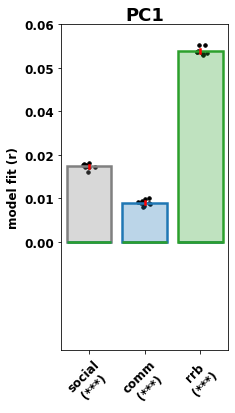

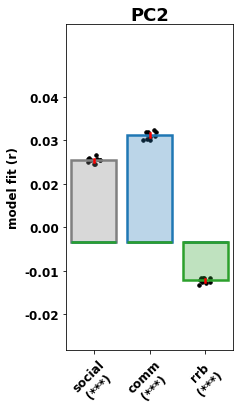

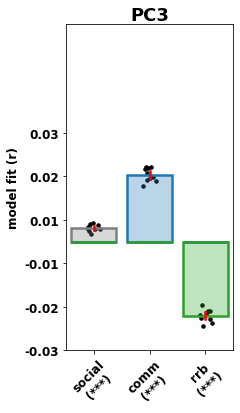

In [75]:
ncols = 3
nrows = 1
plt.figure(figsize=(5,15))
#lbls = ['ados_total','ados_social','ados_comm','ados_rrb']
lbls = ['social','comm','rrb']

for i,key in enumerate(list(pc_bars.keys())):
    #ax = plt.subplot(3,1,i+1)
    plt.figure(figsize=np.array((2,4))*1.5)
    plot_nice_bar(key,pc_bars,
                  ax=ax,figsize=None,
                  dpi=300,fontsize=12,
                  fontsize_star=12,
                  fontweight='bold',
                  line_width=2.5,
                  marker_size=12,title=key,lbls=lbls)
    plt.xticks(rotation=45)
    plt.ylim(-.03,.06)
    
# plt.subplots_adjust(
#     left=None,
#     bottom= None,
#     right=None,
#     top=None,
#     wspace=.5,
#     hspace=.5)

#plt.suptitle('FDs partialled out',fontsize=20)

In [76]:
from scipy.stats import kendalltau
import pingouin as pg
#from pingouin import partial_corr

keys = ['age', 'sex', 'fiq','DSMIV','ados_total', 'ados_social', 'ados_comm', 'ados_rrb','FDs']
k = 0
key = keys[k]

vec = df[key].values[patients]
e = np.isnan(vec)
kres = kendalltau(vec[~e],loso_comp[~e,0])

In [77]:
# CORR PCA W/ SYMOTOMS
corr = kendalltau
corr = pearsonr

keys = ['age', 'sex', 'fiq','DSMIV','ados_total', 'ados_social', 'ados_comm', 'ados_rrb']
npcs = 10 # How many PCs
# Make dataframe
col1 = list()
col2 = list()
vec_age = df_asd['age'].values
for key in keys:
    for i in ['r','p','df']:
        col1.append(key)
        col2.append(i)
        
columns = [col1,col2]
res_corr = pd.DataFrame(np.zeros((npcs,len(col1))),columns=columns)

corr = kendalltau
#corr = pearsonr
for key in keys:
    for pc in range(npcs):
        vec_behav = df_asd[key].values
        vec_pca = loso_comp[:,pc]
        e = np.isnan(vec_behav)
        r,p = corr(vec_behav[~e],vec_pca[~e])
        
        
        dt = pd.DataFrame(np.array([vec_behav[~e],vec_pca[~e],vec_age[~e]]).transpose(),columns=['X','Y','Z'])
        #dt = pd.DataFrame(np.array([vec_behav[~e],vec_pca[~e],twin_pc[~e]]).transpose(),columns=['X','Y','Z'])
        r = pg.partial_corr(data=dt, x='X', y='Y', covar='Z')['r'].values
        p = pg.partial_corr(data=dt, x='X', y='Y', covar='Z')['p-val'].values
        
        
        res_corr.loc[pc].at[(key,'r')] = r
        res_corr.loc[pc].at[(key,'p')] = p
        res_corr.loc[pc].at[(key,'df')] = len(vec_behav[~e])-2


res_corr = res_corr.round(4)
res_corr.to_csv('../Data/PC_corr_deaged.csv')
res_corr

age                    sex                    fiq                 \
        r       p     df       r       p     df       r       p     df   
0 -0.0033  0.9330  659.0  0.0044  0.9095  659.0 -0.0173  0.6679  613.0   
1 -0.0064  0.8696  659.0 -0.0180  0.6437  659.0  0.0272  0.5001  613.0   
2 -0.0011  0.9770  659.0 -0.0006  0.9886  659.0 -0.0406  0.3143  613.0   
3 -0.0010  0.9803  659.0 -0.0064  0.8686  659.0 -0.0150  0.7105  613.0   
4  0.0011  0.9783  659.0 -0.0282  0.4688  659.0 -0.0592  0.1424  613.0   
5 -0.0000  1.0000  659.0 -0.0328  0.3992  659.0 -0.0137  0.7341  613.0   
6 -0.0042  0.9145  659.0  0.0020  0.9586  659.0  0.0404  0.3177  613.0   
7 -0.0039  0.9195  659.0 -0.0991  0.0108  659.0 -0.0319  0.4291  613.0   
8  0.0005  0.9901  659.0  0.0224  0.5651  659.0 -0.0058  0.8865  613.0   
9 -0.0012  0.9754  659.0  0.0059  0.8801  659.0 -0.0303  0.4535  613.0   

    DSMIV  ... ados_total ados_social                ados_comm                 \
        r  ...         df           r       p     df         r       p     df   
0  0.0676  ...      436.0      0.0292  0.5503  419.0    0.0213  0.6633  418.0   
1 -0.0839  ...      436.0      0.0768  0.1157  419.0    0.1093  0.0251  418.0   
2 -0.0776  ...      436.0      0.0655  0.1796  419.0    0.0812  0.0964  418.0   
3  0.0722  ...      436.0     -0.0566  0.2467  419.0   -0.1049  0.0316  418.0   
4 -0.0745  ...      436.0      0.0127  0.7946  419.0   -0.0056  0.9092  418.0   
5  0.0195  ...      436.0      0.0025  0.9597  419.0   -0.0007  0.9893  418.0   
6  0.0604  ...      436.0      0.0176  0.7187  419.0    0.0045  0.9274  418.0   
7 -0.0576  ...      436.0      0.0045  0.9263  419.0   -0.0542  0.2678  418.0   
8  0.1004  ...      436.0     -0.0504  0.3019  419.0   -0.0626  0.2006  418.0   
9  0.0136  ...      436.0      0.0297  0.5434  419.0    0.0346  0.4796  418.0   

  ados_rrb                 
         r       p     df  
0   0.0633  0.2161  381.0  
1  -0.0446  0.3836  381.0  
2   0.0409  0.4243  381.0  
3   0.0008  0.9878  381.0  
4  -0.0827  0.1061  381.0  
5  -0.0350  0.4952  381.0  
6   0.0197  0.7010  381.0  
7   0.0293  0.5677  381.0  
8   0.0014  0.9781  381.0  
9   0.0098  0.8478  381.0  

[10 rows x 24 columns]

In [161]:
import numpy as np
from scipy import stats

def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

In [157]:
keys = ['DSMIV','ados_total','ados_social','ados_comm','ados_rrb']
rvals = np.array([res_corr[(key,'r')].values for key in keys])[:,0:3]
pvals = np.array([res_corr[(key,'p')].values for key in keys])[:,0:3]
degfvals = np.array([res_corr[(key,'df')].values for key in keys])[:,0:3]
nvals = np.array([res_corr[(key,'df')].values for key in keys])[:,0:3]

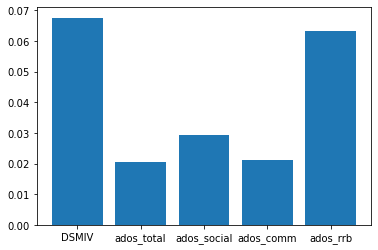

In [159]:
xs = np.arange(5);
ys = rvals[:,0];
plt.bar(xs,ys);
plt.xticks(xs,labels=keys);

In [78]:
%%capture
r01 = np.array([pearsonr(diffmat_resid[:,i],loso_comp[:,0]) for i in tqdm(range(diffmat_asd_flat.shape[1]))])
r02 = np.array([pearsonr(diffmat_resid[:,i],loso_comp[:,1]) for i in tqdm(range(diffmat_asd_flat.shape[1]))])
r03 = np.array([pearsonr(diffmat_resid[:,i],loso_comp[:,2]) for i in tqdm(range(diffmat_asd_flat.shape[1]))])
r04 = np.array([pearsonr(diffmat_resid[:,i],loso_comp[:,3]) for i in tqdm(range(diffmat_asd_flat.shape[1]))])
r05 = np.array([pearsonr(diffmat_resid[:,i],loso_comp[:,4]) for i in tqdm(range(diffmat_asd_flat.shape[1]))])
r06 = np.array([pearsonr(diffmat_resid[:,i],loso_comp[:,5]) for i in tqdm(range(diffmat_asd_flat.shape[1]))])
r07 = np.array([pearsonr(diffmat_resid[:,i],loso_comp[:,6]) for i in tqdm(range(diffmat_asd_flat.shape[1]))])
r08 = np.array([pearsonr(diffmat_resid[:,i],loso_comp[:,7]) for i in tqdm(range(diffmat_asd_flat.shape[1]))])
r09 = np.array([pearsonr(diffmat_resid[:,i],loso_comp[:,8]) for i in tqdm(range(diffmat_asd_flat.shape[1]))])
r10 = np.array([pearsonr(diffmat_resid[:,i],loso_comp[:,9]) for i in tqdm(range(diffmat_asd_flat.shape[1]))])

<AxesSubplot:>

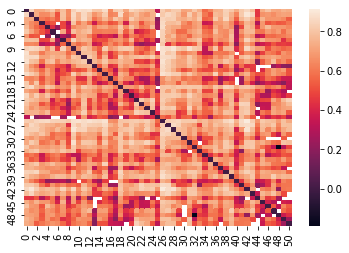

In [79]:
vec = r01
mat1 = squareform(vec[:,0])
mat1[squareform(vec[:,1])>.05/1275/10] = np.nan
sns.heatmap(mat1)

In [80]:
rlbls = pd.DataFrame()
rlbls['rname'] = rnames
rlbls['hem'] = [val.split('-')[0] for val in rnames]
rlbls['net'] = [val.split('-')[1] for val in rnames]
rlbls['roi'] = [val.split('-')[2] for val in rnames]
rlbls['idx'] = np.arange(51)
rlbls.head()

,rname,hem,net,roi,idx
0,LH-Vis-EVC,LH,Vis,EVC,0
1,LH-SomMot-Mot,LH,SomMot,Mot,1
2,LH-DorsAttn-Post,LH,DorsAttn,Post,2
3,LH-DorsAttn-FEF,LH,DorsAttn,FEF,3
4,LH-DorsAttn-PrCv,LH,DorsAttn,PrCv,4


In [81]:
from mne.viz import circular_layout
from mne.viz.circle import _plot_connectivity_circle

In [82]:
node_order = rnames
label_names = rnames

In [83]:
def plot_connGraph(plot_mat,ax=None,n_lines=None,colormap='bwr',title=None,vmin=None,vmax=None):
    
    #plot_mat = mat1
    rnames = ['LH-Vis-EVC','LH-SomMot-Mot','LH-DorsAttn-Post','LH-DorsAttn-FEF','LH-DorsAttn-PrCv','LH-SalVentAttn-ParOper','LH-SalVentAttn-TempOcc','LH-SalVentAttn-FrOper','LH-SalVentAttn-PFCl','LH-SalVentAttn-Med','LH-Limbic-OFC','LH-Limbic-TempPole','LH-Cont-Par','LH-Cont-Temp','LH-Cont-PFCd','LH-Cont-PFCl','LH-Cont-OFC','LH-Cont-PFCv','LH-Cont-pCun','LH-Cont-Cing','LH-Cont-PFCmp','LH-Default-Par','LH-Default-Temp','LH-Default-PFC','LH-Default-PCC','LH-Default-PHC','RH-Vis-EVC','RH-SomMot-Mot','RH-DorsAttn-Post','RH-DorsAttn-FEF','RH-DorsAttn-PrCv','RH-SalVentAttn-TempOccPar','RH-SalVentAttn-PrC','RH-SalVentAttn-FrOper','RH-SalVentAttn-PFCv','RH-SalVentAttn-PFCl','RH-SalVentAttn-Med','RH-Limbic-OFC','RH-Limbic-TempPole','RH-Cont-Par','RH-Cont-Temp','RH-Cont-PFCv','RH-Cont-PFCl','RH-Cont-pCun','RH-Cont-Cing','RH-Cont-PFCmp','RH-Default-Par','RH-Default-Temp','RH-Default-PFCv','RH-Default-PFCm','RH-Default-PCC']
    plot_lbls = rnames

    I = np.hstack((np.arange(25,-1,-1),np.arange(26,51,1)))

    plot_mat = plot_mat[I,:][:,I]
    plot_lbls = np.array(plot_lbls)[I]

    net_colors = dict()
    net_colors['Vis'] = np.array((147,74,146))/ 255
    net_colors['SomMot'] = np.array((103,144,180))/ 255
    net_colors['DorsAttn'] = np.array((50,142,60))/ 255
    net_colors['SalVentAttn'] = np.array((184,102,169))/ 255
    net_colors['Limbic'] = np.array((247,250,201))/ 255
    net_colors['Cont'] = np.array((243,177,82))/ 255
    net_colors['Default'] = np.array((225,99,114)) / 255

    nets = np.array([val.split('-')[1] for val in plot_lbls])
    rois = np.array([val.split('-')[2] for val in plot_lbls])

    node_colors = np.array([net_colors[net] for net in nets ])

    node_angles = circular_layout(label_names, node_order, start_pos=90,
                                  group_boundaries=[0, 26])
    
    _plot_connectivity_circle(con=plot_mat,
            node_names=rois,
            indices=None,
            n_lines=n_lines,
            node_angles=node_angles,
            node_width=None,
            node_height=None,
            node_colors=node_colors,
            facecolor='black',
            textcolor='white',
            node_edgecolor='black',
            linewidth=1.5,
            colormap=colormap,
            vmin=vmin,
            vmax=vmax,
            colorbar=True,
            title=title,
            colorbar_size=.5,
            colorbar_pos=None,
            fontsize_title=12,
            fontsize_names=12,
            fontsize_colorbar=8,
            padding=2.0,
            ax=ax,
            interactive=True,
            node_linewidth=4.0,
            show=True)

In [84]:
# Correlation between motion and diff
pearsonr((diffmat_asd_flat**2).mean(axis=1),FDs)

(-0.034375230063693335, 0.37757542671951483)

In [85]:
# Correlation between motion and diff
pearsonr((diffmat_asd_flat**2).sum(axis=1),FDs)

(-0.03437523040897636, 0.3775754219253681)

In [86]:
for i in range(5):
    print(pearsonr(loso_comp[:,i],FDs))

(-2.1170639108765953e-05, 0.9995665370712485)
(-0.00010275847241981648, 0.9978960512770539)
(-0.0011195989694186143, 0.9770796684042731)
(-5.3707623391777495e-05, 0.9989003516893972)
(0.0027071481375521254, 0.9446163428135217)


In [87]:
for i in range(5):
    print(pearsonr(PCA().fit_transform(cmats_asd_flat)[:,i],FDs))

(-0.0265082218031992, 0.4962804087922899)
(0.16516172112902755, 1.9758751795306065e-05)
(0.025843518841175077, 0.5071461176074004)
(-0.0004191049796073189, 0.9914191070957121)
(0.050236886671640266, 0.19706582435257336)


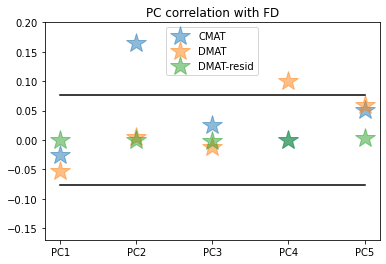

In [88]:
plt.plot([pearsonr(PCA().fit_transform(cmats_asd_flat)[:,i],FDs)[0] for i in range(5)],'*',markersize=20,alpha=.5);
plt.plot([pearsonr(PCA().fit_transform(diffmat_asd_flat)[:,i],FDs)[0] for i in range(5)],'*',markersize=20,alpha=.5);
plt.plot([pearsonr(loso_comp[:,i],FDs)[0] for i in range(5)],'*',markersize=20,alpha=.5);
plt.plot([0,1,2,3,4],[.076,.076,.076,.076,.076],'k-');
plt.plot([0,1,2,3,4],[-.076,-.076,-.076,-.076,-.076],'k-');
plt.title('PC correlation with FD');
plt.xticks(np.arange(5),labels=['PC1','PC2','PC3','PC4','PC5']);
plt.ylim((-.17,.2))
plt.legend(['CMAT','DMAT','DMAT-resid'],loc='upper center')

In [89]:
pearsonr(PCA().fit_transform(cmats_asd_flat)[:,0],FDs)

(-0.0265082218031992, 0.4962804087922899)

In [90]:
pearsonr(PCA().fit_transform(cmats_asd_flat)[:,2],FDs)

(0.025843518841175077, 0.5071461176074004)

In [91]:
abs(vec[:,1]).max()

0.7973179235145647

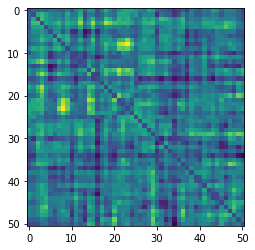

In [92]:
plt.imshow(squareform(diffmat_flat.mean(axis=0)))

In [93]:
vec = r01
mat1 = squareform(vec[:,0])

(array([  3.,   2.,  14.,  37.,  71., 115., 204., 325., 364., 140.]),
 array([-0.18884843, -0.07856135,  0.03172573,  0.14201281,  0.25229989,
         0.36258697,  0.47287405,  0.58316113,  0.69344821,  0.80373529,
         0.91402237]),
 <BarContainer object of 10 artists>)

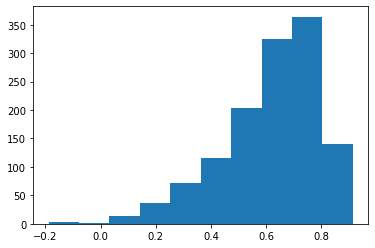

In [94]:
vec = r01
plt.hist(get_triu(squareform(vec[:,0])))

(array([  8.,  47., 105., 209., 294., 253., 179., 111.,  52.,  17.]),
 array([-0.48582199, -0.38065846, -0.27549493, -0.1703314 , -0.06516787,
         0.03999566,  0.14515919,  0.25032272,  0.35548626,  0.46064979,
         0.56581332]),
 <BarContainer object of 10 artists>)

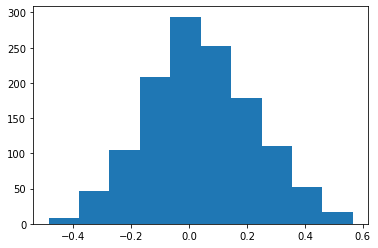

In [95]:
vec = r02
plt.hist(get_triu(squareform(vec[:,0])))

(array([ 14.,  53., 147., 252., 313., 266., 151.,  62.,  14.,   3.]),
 array([-0.47168834, -0.36531976, -0.25895117, -0.15258259, -0.046214  ,
         0.06015458,  0.16652317,  0.27289175,  0.37926034,  0.48562893,
         0.59199751]),
 <BarContainer object of 10 artists>)

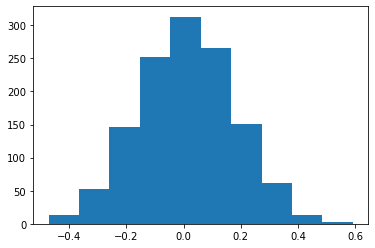

In [96]:
vec = r03
plt.hist(get_triu(squareform(vec[:,0])))

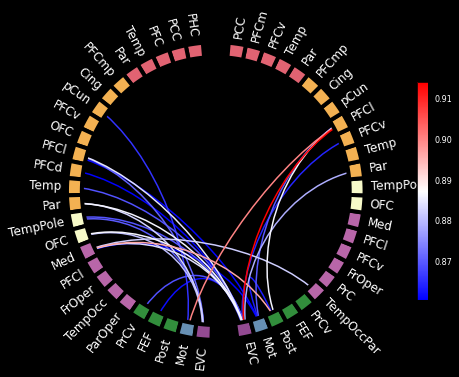

In [97]:
vec = r01
mat1 = squareform(vec[:,0])
#mat1[squareform(vec[:,1])>.05/1275] = np.nan
#plot_connGraph(mat1,colormap='bwr')
plot_connGraph(mat1,colormap='bwr',n_lines=25)

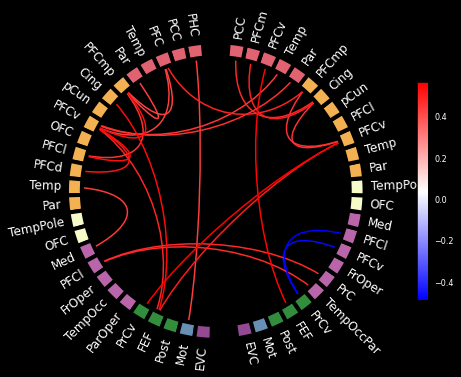

In [98]:
vec = r02
mat1 = squareform(vec[:,0])
#mat1[squareform(vec[:,1])>.05/1275] = np.nan
#plot_connGraph(mat1,colormap='bwr')
plot_connGraph(mat1,colormap='bwr',n_lines=25)

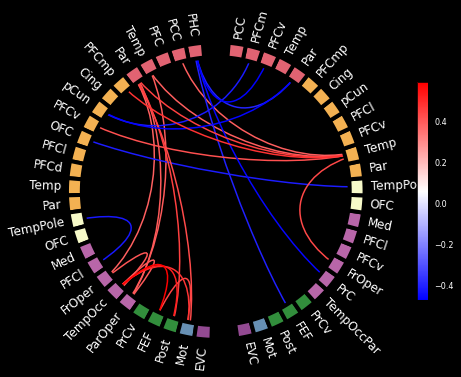

In [99]:
vec = r03
mat1 = squareform(vec[:,0])
#mat1[squareform(vec[:,1])>.05/1275] = np.nan
#plot_connGraph(mat1,colormap='bwr')
plot_connGraph(mat1,colormap='bwr',n_lines=25)

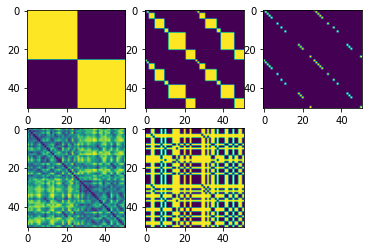

In [100]:
model_hem = np.zeros((51,51))-1
model_net = np.zeros((51,51))-1
model_roi = np.zeros((51,51))-1
model_dist = np.load('../Data/YeoAtlas/roi_distmat.npy')
model_pfc = np.zeros((51,51))-1
for i in range(51):
    for j in range(51):
        if rlbls['hem'].values[i]==rlbls['hem'].values[j]:
            model_hem[i,j]=1
        if rlbls['net'].values[i]==rlbls['net'].values[j]:
            model_net[i,j]=1
        if rlbls['roi'].values[i]==rlbls['roi'].values[j] and sum(rlbls['roi'].values[i]==rlbls['roi'].values)==2:
            model_roi[i,j]=1
        if ('pfc' in rlbls['roi'].values[i].lower()) and not ('pfc' in rlbls['roi'].values[j].lower()):
            model_pfc[i,j]=1
        if ('pfc' in rlbls['roi'].values[j].lower()) and not ('pfc' in rlbls['roi'].values[i].lower()):
            model_pfc[i,j]=1
        if ('fef' in rlbls['roi'].values[i].lower()) and not ('fef' in rlbls['roi'].values[j].lower()):
            model_pfc[i,j]=1
        if ('fef' in rlbls['roi'].values[j].lower()) and not ('fef' in rlbls['roi'].values[i].lower()):
            model_pfc[i,j]=1
        if ('prc' in rlbls['roi'].values[i].lower()) and not ('prc' in rlbls['roi'].values[j].lower()):
            model_pfc[i,j]=1
        if ('prc' in rlbls['roi'].values[j].lower()) and not ('prc' in rlbls['roi'].values[i].lower()):
            model_pfc[i,j]=1
        if ('ofc' in rlbls['roi'].values[i].lower()) and not ('ofc' in rlbls['roi'].values[j].lower()):
            model_pfc[i,j]=1
        if ('ofc' in rlbls['roi'].values[j].lower()) and not ('ofc' in rlbls['roi'].values[i].lower()):
            model_pfc[i,j]=1
        
plt.subplot(2,3,1)    
plt.imshow(model_hem)
plt.subplot(2,3,2)  
plt.imshow(model_net)
plt.subplot(2,3,3)  
plt.imshow(model_roi)
plt.subplot(2,3,4)  
plt.imshow(model_dist)
plt.subplot(2,3,5)  
plt.imshow(model_pfc)

([], [])

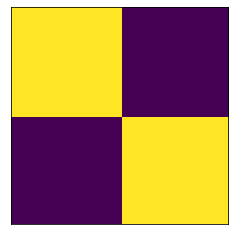

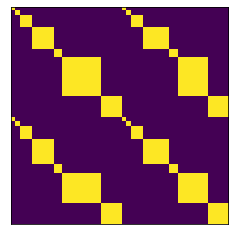

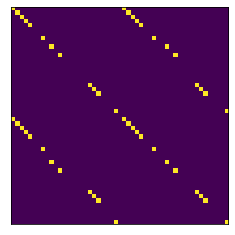

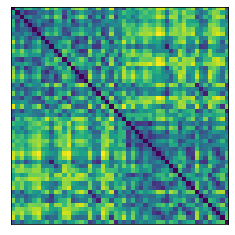

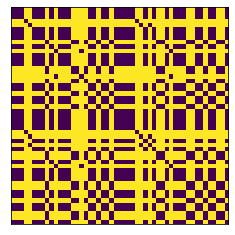

In [101]:
plt.figure()
plt.imshow(model_hem);plt.xticks([]);plt.yticks([])
plt.figure()
plt.imshow(model_net);plt.xticks([]);plt.yticks([])
plt.figure()
plt.imshow(model_roi);plt.xticks([]);plt.yticks([])
plt.figure()
plt.imshow(model_dist);plt.xticks([]);plt.yticks([])
plt.figure()
plt.imshow(model_pfc);plt.xticks([]);plt.yticks([])

In [102]:
pc_mats = [squareform(r01[:,0]),squareform(r02[:,0]),squareform(r03[:,0])]
models = [model_hem,model_net,model_roi]
net_rsa_res = np.zeros((3,3))
for p in range(3):
    for m in range(3):
        net_rsa_res[p,m] = kendalltau(get_triu(pc_mats[p]),get_triu(models[m]))[0]

In [103]:
#print(diffmat_resid_samples.shape)
models = [model_hem,model_net,model_roi,model_dist]

ns = diffmat_resid_samples.shape[2]
ni = 10
nm = len(models)
rsa_res_net = np.zeros((ns,nm,ni))

for s in tqdm(range(ns)):
    for m in range(nm):
        for i in range(ni):
            rsa_val = fit_rsa(rdm_data=squareform(diffmat_resid_samples[i,:,s]), rdm_model=models[m], measure='pearson', cov=None)
            rsa_res_net[s,m,i] = rsa_val

100%|██████████| 661/661 [00:03<00:00, 176.15it/s]


In [104]:
rsa_res_net.shape

(661, 4, 10)

In [105]:
loso_comp.shape

(661, 660)

In [106]:
npc = 3
pc_fit = np.zeros((npc,nm,ni))
meas_fit = np.zeros((npc,nm,ni))
for pc in range(npc):
    for m in range(nm):
        for i in range(ni):
            v1 = rsa_res_net[:,m,i]
            v2 = loso_comp[:,pc]
            pc_fit[pc,m,i] = np.corrcoef(v1,v2)[0,1]
pc_fit.shape

(3, 4, 10)

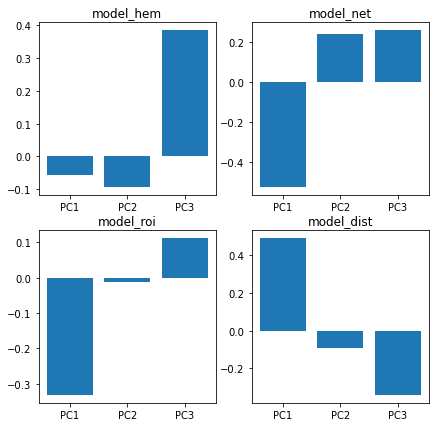

In [107]:
plt.figure(figsize=(7,7))
model_names = ['model_hem','model_net','model_roi','model_dist']
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.bar([0,1,2],pc_fit.mean(axis=2)[:,i]);
    plt.xticks([0,1,2],labels=['PC1','PC2','PC3']);
    plt.title(model_names[i])

In [108]:
pca_ = PCA(n_components=3)
pca_.fit(diffmat_resid)

PCA(n_components=3)

In [109]:
comps = pca_.fit_transform(diffmat_resid)

In [110]:
#pca_.inverse_transform(comps_play).shape

In [111]:
comps_play = comps.copy()
comps_play[:,np.arange(3)!=0]=0
mats_pc1 = np.array([squareform(pca_.inverse_transform(comps_play)[s,:]) for s in range(comps_play.shape[0])])

comps_play = comps.copy()
comps_play[:,np.arange(3)!=1]=0
mats_pc2 = np.array([squareform(pca_.inverse_transform(comps_play)[s,:]) for s in range(comps_play.shape[0])])

comps_play = comps.copy()
comps_play[:,np.arange(3)!=2]=0
mats_pc3 = np.array([squareform(pca_.inverse_transform(comps_play)[s,:]) for s in range(comps_play.shape[0])])

In [112]:
comps

array([[-0.64933221,  0.24725407,  0.44559356],
       [-0.65074291,  0.30482753, -0.22750942],
       [-0.17255688, -0.06292934, -0.80223976],
       ...,
       [-1.00366973,  0.18840541, -0.45970159],
       [-0.41314979, -0.31786724,  0.43017565],
       [-1.01567561,  0.61911481, -0.48895505]])

In [113]:
v1 = pca_.inverse_transform(np.array([-0.64933221,  0.24724724,  0.44550784])[np.newaxis,:])
v2 = pca_.inverse_transform(np.array([-0.65074291,  0.30483132, -0.22748207])[np.newaxis,:])
np.corrcoef(v1,v2)

array([[1.        , 0.26743224],
       [0.26743224, 1.        ]])

In [114]:
v1 = pca_.inverse_transform(np.array([0, 0,  .44])[np.newaxis,:])
v2 = pca_.inverse_transform(np.array([0, 0,  -.22])[np.newaxis,:])
np.corrcoef(v1,v2)

array([[ 1., -1.],
       [-1.,  1.]])

In [115]:
# npc = 3
# ns = comps_play.shape[0]
# pc_fit = np.zeros((ns,nm,npc,ni))
# for s in tqdm(range(comps_play.shape[0])):
#     for m in range(nm):
#         for i in range(ni):
#             pc_fit[s,m,0,i] = fit_rsa(rdm_data=mats_pc1[s,:,:], rdm_model=models[m], measure='kendall', cov=None)
#             pc_fit[s,m,1,i] = fit_rsa(rdm_data=mats_pc2[s,:,:], rdm_model=models[m], measure='kendall', cov=None)
#             pc_fit[s,m,2,i] = fit_rsa(rdm_data=mats_pc3[s,:,:], rdm_model=models[m], measure='kendall', cov=None)

In [116]:
## FIT RSA to diffmats then corr with PCs

In [117]:
models = [model_hem,model_net,model_roi,model_dist]
model_names = ['model_hem','model_net','model_roi','model_dist']

In [118]:
#vals = [(diffmat_resid[s,:]*get_triu(model_hem)).sum() for s in range(ns)]
#vals = [(diffmat_resid[s,:]*get_triu(model_net)).sum() for s in range(ns)]
#vals = [(diffmat_resid[s,:]*get_triu(model_roi)).sum() for s in range(ns)]

In [119]:
vals = [fit_rsa(rdm_data=squareform(diffmat_resid[s,:]), rdm_model=model_hem,measure='kendall') for s in range(ns)]
print(pearsonr(vals,loso_comp[:,0]))
print(pearsonr(vals,loso_comp[:,1]))
print(pearsonr(vals,loso_comp[:,2]))
print('___________________________')
vals = [fit_rsa(rdm_data=squareform(diffmat_resid[s,:]), rdm_model=model_net,measure='kendall') for s in range(ns)]
print(pearsonr(vals,loso_comp[:,0]))
print(pearsonr(vals,loso_comp[:,1]))
print(pearsonr(vals,loso_comp[:,2]))
print('___________________________')
vals = [fit_rsa(rdm_data=squareform(diffmat_resid[s,:]), rdm_model=model_roi,measure='kendall') for s in range(ns)]
print(pearsonr(vals,loso_comp[:,0]))
print(pearsonr(vals,loso_comp[:,1]))
print(pearsonr(vals,loso_comp[:,2]))
print('___________________________')
vals = [fit_rsa(rdm_data=squareform(diffmat_resid[s,:]), rdm_model=model_dist,measure='kendall') for s in range(ns)]
print(pearsonr(vals,loso_comp[:,0]))
print(pearsonr(vals,loso_comp[:,1]))
print(pearsonr(vals,loso_comp[:,2]))
print('___________________________')

(-0.052383307680829626, 0.17857833885530622)
(-0.09099738717318771, 0.019285605153092265)
(0.38170183290110893, 2.3609561966093378e-24)
___________________________
(-0.5303489645062234, 3.1953995868654837e-49)
(0.23886171961911531, 4.979676159010482e-10)
(0.26847191373328605, 2.241346865445239e-12)
___________________________
(-0.3206541486862274, 2.8491089961104895e-17)
(-0.03051041392147795, 0.4335578567807077)
(0.13766180630251265, 0.0003859816005470393)
___________________________
(0.5083204182287531, 1.016833828879702e-44)
(-0.08933213194058956, 0.021620548977410635)
(-0.3377056641676078, 4.2751964847439058e-19)
___________________________


In [120]:
# print(np.corrcoef(vals,loso_comp[:,0])[0,1].round(3))
# print(np.corrcoef(vals,loso_comp[:,1])[0,1].round(3))
# print(np.corrcoef(vals,loso_comp[:,2])[0,1].round(3))

In [121]:
import numpy as np
from scipy import stats

def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

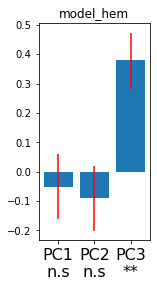

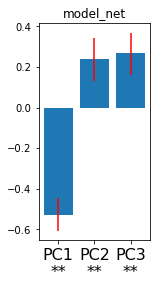

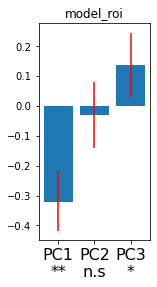

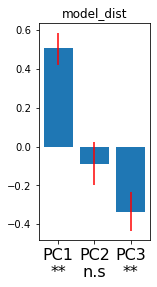

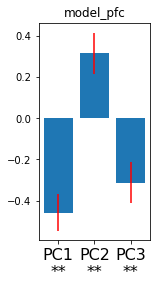

In [122]:
models = [model_hem,model_net,model_roi,model_dist,model_pfc]
model_names = ['model_hem','model_net','model_roi','model_dist','model_pfc']

for m in range(len(models)):
    plt.figure(figsize=(2,4))
    vals = [fit_rsa(rdm_data=squareform(diffmat_resid[s,:]), rdm_model=models[m],measure='kendall') for s in range(ns)]
    bonf = 12
    xs = [0,1,2]
    res = np.array([pearsonr_ci(x=np.array(vals),y=loso_comp[:,i],alpha=0.05/bonf) for i in range(3)])
    #print(res.shape) #r, p, lo, hi
    ys = res[:,0]
    plt.bar(xs,ys);
    plt.errorbar(xs,ys,yerr=abs(np.array([ys,ys])-res[:,2::].transpose()),fmt='r ');
    lbls = ['PC1','PC2','PC3'];
    for i in range(3):
        stars = [1,.05/bonf,.001/bonf]
        stars_lbls = ['n.s','*','**']
        stars_lbls[max(np.argwhere(res[i,1]<stars))[0]]
        lbls[i] = lbls[i]+'\n'+stars_lbls[max(np.argwhere(res[i,1]<stars))[0]]
    plt.xticks(xs,labels=lbls,fontsize=16);
    plt.title(model_names[m])

In [123]:
data.keys()

dict_keys(['Z_mu', 'Z_sigma', 'Z', 'S_mu', 'S_sigma', 'S', 'Z_sample100', 'S_sample100', 'recon_td_mu', 'recon_asd_mu', 'recon_twin_mu', 'recon_td_samples', 'recon_asd_samples', 'recon_twin_samples', 'Z_asd_sample10', 'S_asd_sample10'])

In [124]:
df.columns

Index(['Unnamed: 0', 'participant_id', 'diag', 'age', 'sex', 'fiq', 'site',
       'DSMIV', 'ados_total', 'ados_social', 'ados_comm', 'ados_rrb',
       'dataset', 'dataset_id', 'site_id', 'sites_bal'],
      dtype='object')

In [125]:
!date

Fri Jun 17 10:00:49 EDT 2022
